In [0]:
'''
Changes compared to try7_day:
* instead of 24hour average bot takes 8 hours
* game initialization now can start with either BTC or EUR, while, in original try 7 it was only BTC
* crash of game removed
* updated reward function (tax usage)
'''

'\nChanges compared to try7_day:\n* instead of 24hour average bot takes 8 hours\n* game initialization now can start with either BTC or EUR, while, in original try 7 it was only BTC\n* crash of game removed\n'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/YouTube/BTC_bot/deepQ/')
os.getcwd()

'/content/drive/My Drive/YouTube/BTC_bot/deepQ'

In [0]:
'''
Data work
'''
! pip install cbpro
import cbpro
import pandas as pd
import numpy as np
import datetime
import time

def innitPriceHistory(days):
    '''
    Gets innitial data needed for feature calc (20 days of minute data).
    * days - days to go back
    '''
    # start
    tik = time.time()
    
    public_client = cbpro.PublicClient()  # connect to public API
    a = public_client.get_product_historic_rates('BTC-EUR', granularity=60)  # granularity=seconds
    
    maxReq = len(a)  # sets request size
    requestsNeeded = round((days+21)*24*60/maxReq+0.5)  # calcs the number of requests needed to get innit data, +21 for features  
      
    startDates = [a[0][0]-((maxReq)*60)*(i+1) for i in range(requestsNeeded)]  # gets timestamps
    endDates = [i+((maxReq)*60) for i in startDates]
    
    startDateTime = [datetime.datetime.utcfromtimestamp(i).strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3]+'Z' for i in startDates]  # turns timestamps to ISO 8601
    endDateTime = [datetime.datetime.utcfromtimestamp(i).strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3]+'Z' for i in endDates]                
    
    for i in range(1, len(startDateTime)):  # gets data for all of the time needed
        b = public_client.get_product_historic_rates('BTC-EUR', granularity=60, start=startDateTime[i], end=endDateTime[i])
        # print(len(b))
        for k in b:
            a.append(k)
        time.sleep(2)  # due to public client limits
        
    b = public_client.get_product_historic_rates('BTC-EUR', 
                                                 granularity=60, 
                                                 start=datetime.datetime.utcfromtimestamp(endDates[0]+60).strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3]+'Z',
                                                 end=public_client.get_time().get('iso'))  # adds the most recent data
    
    for k in b:  # appends the most recent data
        a.append(k)
    
    a = pd.DataFrame(a, columns=['time', 
                                'low',
                                'high',
                                'open',
                                'close',
                                'volume']) 
    
    a.drop_duplicates(inplace=True)
    dates = [datetime.datetime.utcfromtimestamp(i).strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3]+'Z' for i in a.time]  # converts time
    a['time'] = dates
    a = a.sort_values(by='time').reset_index(drop=True)
    
    tok = time.time()  # checks the end time
    print('Innit data time passed: ', round(tok-tik))
    return(a)

def prepData(df):
  '''
  Converts coninbase df to df with time features.
  * df - coinbase df, see innitPrice history().
  '''
  # time features
  minute_features = {
    '2min':2,
    '3min':3,
    '4min':4,
    '5min':5,
    '10min':10,
    '30min':30,
    '1h':60,
    '2h':120,
    '5h':300,
    '10h':600,
    '24h':1440,
    '2d':2880,
    '5d':7200,
    '10d':14400,
    '20d':28800
  }

  # drop unused columns
  df.drop(columns=['low',
                    'high',
                    'open',
                    'volume'], inplace=True)
  
  df.rename(columns={'close':'Close'}, inplace=True)  # rename column to correspond to latter code

  # add features
  for i in minute_features:
      df[i] = df.Close.rolling(minute_features[i]).mean()  # rolling mean

  # weight against close price
  for i in range(2,len(df.columns)):  # 2, since 0 and 1 are time and close
    df[df.columns[i]] = df[df.columns[i]]/df['Close']

  df.dropna(inplace=True)
  df.reset_index(drop=True, inplace=True)

  return(df)

     |████████████████████████████████| 204kB 9.4MB/s 
     |████████████████████████████████| 368kB 45.3MB/s 
     |████████████████████████████████| 593kB 44.8MB/s 
  Created wheel for websocket-client: filename=websocket_client-0.40.0-py2.py3-none-any.whl size=198284 sha256=24c489f0a37fbf6790e112d6be7497fe62b56c3611d95435426f6d11caf1b856
  Stored in directory: /root/.cache/pip/wheels/b0/d2/e2/8275906d09421f074dc2d05381643a0b4b3c4945d845b14bf9
Successfully built websocket-client
ERROR: tensorflow-datasets 1.3.0 has requirement requests>=2.19.0, but you'll have requests 2.13.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.13.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.10.0 which is incompatible.
ERROR: google-api-core 1.14.3 has requirement requests<3.0.0dev,>=2.18.0, but you'll have requests 2.13.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement f

In [0]:
'''
Trading training module for BTC bot. Deep Q learning version
'''

# check line 31 to load/start new modelling

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
import keras
import random
import numpy as np
import pandas as pd
from operator import add


class TraderMan(object):
    init_BTC_wallet = 1  # BTC wallet in BTC
    init_EUR_wallet = 0  # EUR wallet in BTC
    
    init_trade_tax = 0.005  # tax ratio =0.5percent
    
    def __init__(self, BTC=init_BTC_wallet, EUR=init_EUR_wallet, trade_tax=init_trade_tax):
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = 0.0005
        # self.model = self.network()
        self.model = self.network('bitMcCoin_8-hour.hdf5')
        self.epsilon = 0
        self.actual = []
        self.memory = []
        
        self.BTC = BTC
        self.EUR = EUR
        self.trade_tax = trade_tax
        
        self.close_price = 1  # sets a variable to remember last closing price
        self.nextClosePrice = 1  # sets a variable for the upcoming price to evaluate current decision, at try5 made to be an average of a time period
        
        self.steps_done = 0 # calcs different steps taken
        self.BUY = 0
        self.SELL = 0 
        
        self.old_position = [1, 0]
        
    def last_action(self):
        '''
        Returns last action as sell or buy in binary (0,1).
        '''
        if self.EUR==0:
            return 1  # BUY
        else:
            return 0  # SELL
        
    def get_state(self, df, line_no):
        '''
        Gets input values
        '''
        state = df.drop(columns=['time','Close']).iloc[line_no].to_list()
        trade_pos = self.last_action()  # current state of the wallet
        state.append(trade_pos)

        return np.asarray(state)
    
    def get_reward(self, in_coins=True, next_interval=False, raw=False, old_position=False):
        '''
        Returns wallet information. BTC and EUR
        
        in_coins - return wallet amount in BTC or EUR. Default BTC.
        next_interval - return wallet for next close price
        raw - return wallet in BTC, EUR or just one. see in_coins
        old_position - should the price be retuned on position before the trade or after
        '''
        # determines the price and wallet needed
        if next_interval==False:
          priceUsed = self.close_price
        else:
          priceUsed = self.nextClosePrice
          
        if old_position == False:  # checks for what to calc the prices, old position or new
          used_BTC = self.BTC
          used_EUR = self.EUR
        else:
          used_BTC = self.old_position[0]
          used_EUR = self.old_position[1]
        
        # returns wallet info
        if raw == True:
          return used_BTC, used_EUR
        else:
          if in_coins == True:
              return used_BTC, (used_EUR*(1/priceUsed))
          else:
              return (used_BTC*priceUsed), used_EUR

    def set_reward(self, trader, crash, action):
        ''' 
        Returns positive rewards for increasement of total portfolio, 
        evaluated based on the next interval price.
        '''
        self.reward = 0
        
        # sets the score even if the action can't be processed due to lack of EUR/BTC in wallets
        if np.array_equal(action, [1, 0, 0]):  # BUY
          old_score = self.close_price
          new_score = self.nextClosePrice * (1-self.trade_tax)
        elif np.array_equal(action, [0, 0, 1]):  # SELL
          new_score = self.close_price * (1-self.trade_tax)
          old_score = self.nextClosePrice
        else: 
          new_score = 1
          old_score = 1
        
        delta_score = (new_score - old_score)/old_score*100
    
        if delta_score != 0:
            self.reward = delta_score
            
        # if old_score != new_score:            
        #   print('Price delta: %.2f \n' %delta_score, 
        #         'Old_score: ', old_score, '\n',
        #         'New_score: ', new_score, '\n',
        #         'Old position: ', self.old_position, '\n',
        #         'New position: ', self.get_reward(raw=True), '\n',
        #         'Current price: ', self.close_price, '\n',
        #         'Reward price: ', self.nextClosePrice, '\n'
        #        )

        return self.reward
        
    def step(self, close_price, action):
        '''
        close - closing price
        action - tanh output from nnet
        '''
        self.steps_done += 1
        
        a = action
        
        # readability
        EUR = self.EUR
        BTC = self.BTC
        trade_tax = self.trade_tax
        
        # update old price
        self.close_price = close_price
        
        if np.array_equal(a, [1, 0, 0]):  # BUY
            new_wallet = EUR*(1/close_price)
            new_wallet -= trade_tax*new_wallet
            self.BTC = new_wallet
            self.EUR = 0
            self.BUY += 1
        elif np.array_equal(a, [0, 0, 1]):  # SELL
            new_wallet = BTC*close_price
            new_wallet -= trade_tax*new_wallet
            self.EUR = new_wallet
            self.BTC = 0
            self.SELL += 1
        
    def network(self, saved_model=None):
        '''
        Builds the network.
        '''
        if saved_model:
            model = keras.models.load_model(saved_model)
        else:
          model = Sequential()
          model.add(Dense(output_dim=120, activation='relu', input_dim=16))
          model.add(Dropout(0.15))
          model.add(Dense(output_dim=120, activation='relu'))
          model.add(Dropout(0.15))
          model.add(Dense(output_dim=120, activation='relu'))
          model.add(Dropout(0.15))
          model.add(Dense(output_dim=3, activation='softmax'))
          opt = Adam(self.learning_rate)
          model.compile(loss='mse', optimizer=opt)
        
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def replay_new(self, memory):
        self.BTC = 1
        self.EUR = 0
        
        self.close_price = 1  # sets a variable to remember last closing price
        self.steps_done = 0
        self.BUY = 0
        self.SELL = 0
        
        if len(memory) > 1000:
            minibatch = random.sample(memory, 1000)
        else:
            minibatch = memory
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][np.argmax(action)] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

    def train_short_memory(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape((1, 16)))[0])
        target_f = self.model.predict(state.reshape((1, 16)))
        target_f[0][np.argmax(action)] = target
        self.model.fit(state.reshape((1, 16)), target_f, epochs=1, verbose=0)
    

Innit data time passed:  525
Started with BTC
--------------------------------------
Game 1 

Selected lines:  0 40866
Prices:          8355.36 6821.19 

       EUR: 7671.03 
       BTC: 1.12 
       Steps done:  13276 0.32 
       BUYs done:   29 
       SELLs done:  29 
       Total done:  0.00 
       Random done:  0 



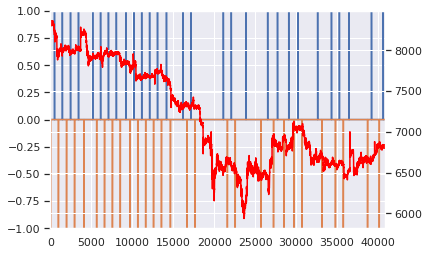

-------------------------------------- 

Mean score:  1.1235844429170674


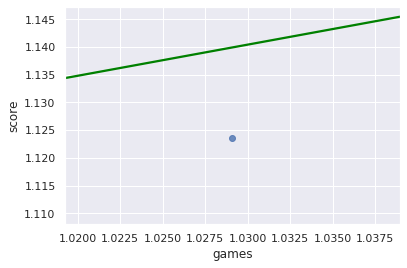

In [0]:
from random import randint
# from TraderMan import TraderMan
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random

# based on
# https://towardsdatascience.com/how-to-teach-an-ai-to-play-games-deep-reinforcement-learning-28f9b920440a
# https://github.com/maurock/snake-ga

# data load and setting
df = innitPriceHistory(30)  # sets testing period to 30 days
testDf = prepData(df)
testLen = len(testDf)

reward_period = (8*60)  # at which point should the nextClosePrice be taken to measure the succesess of an action, takes average of the named amount, i.e. 1440 average price for the whole day after the trade.

lastPossibleLine = testLen-reward_period-1

games_to_play = 1

class Game:
    
    def __init__(self):
        self.score = 0
        self.crash = False
        self.steps = 0
        self.trader = Trader(self)
        
class Trader:
    
    def __init__(self, game):
        self.steps = 0
        self.trade_pos = 1
        self.last_score = 0
        
    def do_move(self, action, game, agent, closePrice, nextClosePrice):
        '''
        Checks if move is valid and if so sends it to TraderMan agent.
        '''
        self.trade_pos = agent.last_action()  # check witch wallet is active  
        agent.old_position = agent.get_reward(raw=True)  # updates the old position for reward calc (see set_reward())
        emptyAction = [0, 1, 0]  # do nothing action
        self.empty_move = 0 # checks if the action was empty
        
        if np.array_equal(action, [1, 0, 0]) and self.trade_pos == 1:
            game.crash = False
            # print('BUY crash')
            agent.step(closePrice, emptyAction)  # sends an empty step
            self.empty_move = 1
        elif np.array_equal(action, [0, 0, 1]) and self.trade_pos == 0:
            game.crash = False
            # print('SELL crash')
            agent.step(closePrice, emptyAction)  # send an empty step
            self.empty_move = 1
        else:
            agent.step(closePrice, action)
            self.empty_move = 0
            
        agent.nextClosePrice = nextClosePrice            
        game.score = sum(agent.get_reward())
            
def get_record(score, record):
        if score >= record:
            return score
        else:
            return record
        
def plot_seaborn(array_counter, array_score):
    sns.set(color_codes=True)
    ax = sns.regplot(np.array([array_counter])[0], np.array([array_score])[0], color="b", x_jitter=.1, line_kws={'color':'green'})
    ax.set(xlabel='games', ylabel='score')
    plt.show()
    
def initialize_game(trader, game, agent, line, df, closePrice, nextClosePrice):
    game.crash = False
    state_init1 = agent.get_state(df, line)
    do_rand_move = randint(0, 2)
    if do_rand_move == 1:
      action = [0, 0, 1]
      print('Started with EUR')
    else:
      action = [0, 1, 0]
      print('Started with BTC')
    trader.do_move(action, game, agent, closePrice, nextClosePrice)
    state_init2 = agent.get_state(df, line)
    reward1 = agent.set_reward(trader, game.crash, action)
    agent.remember(state_init1, action, reward1, state_init2, game.crash)
    agent.replay_new(agent.memory)
            
            
def run():
    agent = TraderMan()
    counter_games = 1
    score_plot = []
    counter_plot = []
    record = 0
    line = 0
    closePrice = 1
    nextClosePrice = 1
    while counter_games <= games_to_play:
        # Initialize classes
        random_steps = 0  # random steps taken
        game = Game()
        trader1 = game.trader
        
        # start gaming
        while not game.crash:
            # set game counter
            timeCounter = reward_period
            # testing set selection
            initLine = 0
            endLine = lastPossibleLine
            line = initLine
            closePrice = testDf.Close[line]
            nextClosePrice = testDf.Close[line: line+reward_period].mean()
            initialize_game(trader1, game, agent, line, testDf, closePrice, nextClosePrice)
            
            plotDf = pd.DataFrame(index=range(initLine, endLine), columns=['random', 'BUY', 'SELL'], data=0)
            
            # print some trackables
            print('--------------------------------------')
            print('Game', counter_games, '\n')
            print('Selected lines: ', initLine, endLine)
            print('Prices:         ', testDf.Close[initLine], testDf.Close[endLine], '\n')
            
            # selects new price state
            for memb in range(initLine+1, endLine+1):
              #get old state
              state_old = agent.get_state(testDf, line)
                
              # set up new state
              line = memb
            
              # predict action based on the old state
              prediction = agent.model.predict(state_old.reshape((1,16)))
              final_move = to_categorical(np.argmax(prediction[0]), num_classes=3)
              # print('-----STATE------')
              # print(state_old)
              # print('-----FINAL_MOVE------')
              # print(final_move)

              # check if enough time passed from last move
              if timeCounter >= reward_period:    
                #perform new move and get new state
                closePrice = testDf.Close[line]
                nextClosePrice = testDf.Close[line: line+reward_period].mean()
                trader1.do_move(final_move, game, agent, closePrice, nextClosePrice)
                if np.array_equal(final_move, [1, 0, 0]) and trader1.empty_move == 0:
                      plotDf.BUY[line] = 1
                      timeCounter = 0
                elif np.array_equal(final_move, [0, 0, 1]) and trader1.empty_move == 0:
                      plotDf.SELL[line] = -1
                      timeCounter = 0
              else: timeCounter += 1

              state_new = agent.get_state(testDf, line)
                
              #set reward for the new state
              reward = agent.set_reward(trader1, game.crash, final_move)
                
              # check if it's not the end of cycle
              if memb >= endLine:
                game.crash = True
                
              #train short memory base on the new action and state
              agent.train_short_memory(state_old, final_move, reward, state_new, game.crash)
                
              # store the new data into a long term memory
              agent.remember(state_old, final_move, reward, state_new, game.crash)
              record = get_record(game.score, record)
                
              # move on if game crashed
              if game.crash == True:
                break
                
        print(
              '       EUR: %.2f' %sum(agent.get_reward(in_coins=False)), '\n',             # portfolio value at the end in EUR
              '      BTC: %.2f' %sum(agent.get_reward()), '\n',                            # portfolio value at the end in BTC
              '      Steps done: ',  agent.steps_done,                                     # total number of steps done
              '%.2f' %(agent.steps_done/testLen), '\n',                             # proportion of steps taken compared to total amount of intervals
              '      BUYs done:  ', agent.BUY, '\n',                                       # total number of buy steps
              '      SELLs done: ', agent.SELL, '\n',                                      # total number of sell steps
              '      Total done:  %.2f' %((agent.SELL+agent.BUY)/(agent.steps_done+1)), '\n',  # proportion of sum(BUY, SELL) steps compared to total amount of steps taken
              '      Random done: ', random_steps, '\n'                                    # random steps taken (see epsilon)
             )
        # plot dataframe
        plotDf['Close'] = testDf.Close[initLine:endLine]

        ax1 = plotDf[['BUY', 'SELL']].plot(legend=False)  # BUY is 1, SELL -1 on the plot
        ax1.set_ylim([-1,1])
        ax2 = ax1.twinx()
        ax2.spines['right'].set_position(('axes', 1.0))
        plotDf['Close'].plot(ax=ax2, color='red', legend=False)
        plt.show()

        print('--------------------------------------', '\n')
        agent.replay_new(agent.memory)
        score_plot.append(game.score)
        counter_plot.append(counter_games)
        # agent.model.save('bitMcCoin_1-hour.hdf5')
        if counter_games%10==0:
              print('Mean score: ', np.mean(score_plot[-10:]))
              plot_seaborn(counter_plot[-10:], score_plot[-10:])
        counter_games += 1
        plotDf.to_csv('plotDf.csv')
    print('Mean score: ',np.average(score_plot))
    plot_seaborn(counter_plot, score_plot)
    


if __name__ == '__main__':
    run()